In [1]:
import numpy as np
import tensorflow
import pickle
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from random import randint

In [2]:
import os
os.listdir("/kaggle/input/coffee/Coffee Unzipped")

['Miner', 'Leaf rust', 'Cerscospora', 'Phoma', 'Healthy']

In [3]:
EPOCHS = 50
INIT_LR = 0.01
BS = 64
default_image_size = tuple((128,128))
image_size = 0
directory_root = '/kaggle/input/coffee'
width = 128
height = 128
depth = 3
inputShape = (height,width,depth)

In [4]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None
image_list, label_list, directory_list = [], [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for plant_folder in root_dir :
        plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")
        
        for disease_folder in plant_disease_folder_list :
            # remove .DS_Store from list
            if disease_folder == ".DS_Store" :
                plant_disease_folder_list.remove(disease_folder)

        for plant_disease_folder in plant_disease_folder_list:
            print(f"[INFO] Processing {plant_disease_folder} ...")
            plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}/")
                
            for single_plant_disease_image in plant_disease_image_list :
                if single_plant_disease_image == ".DS_Store" :
                    plant_disease_image_list.remove(single_plant_disease_image)

            for image in plant_disease_image_list[:3000]:
                image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True or image_directory.endswith(".jpeg") == True or image_directory.endswith(".JPEG") == True:
                    directory_list.append(image_directory)
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)
    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error --- : {e}")

[INFO] Loading images ...
[INFO] Processing Miner ...
[INFO] Processing Leaf rust ...
[INFO] Processing Cerscospora ...
[INFO] Processing Phoma ...
[INFO] Processing Healthy ...
[INFO] Image loading completed


In [5]:
image_size = len(image_list)
image_size

15000

In [6]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer, open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)
print(label_binarizer.classes_)

['Cerscospora' 'Healthy' 'Leaf rust' 'Miner' 'Phoma']


In [7]:
np_image_list = np.array(image_list, dtype=np.float16) / 225
print("[INFO] Spliting data to train, test")
X_train, x_test, Y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42)
x_val = len(X_train)
x_testval = len(x_test)
y_val = len(Y_train)
y_testval = len(y_test)

x_val, x_testval, y_val, y_testval

[INFO] Spliting data to train, test


(12000, 3000, 12000, 3000)

In [8]:
train_datagen = ImageDataGenerator (rotation_range=45, width_shift_range=0.4, 
                                    height_shift_range=0.3, shear_range=0.4, zoom_range=0.5, 
                                    fill_mode='nearest', horizontal_flip=True,validation_split=0.2)

In [9]:
def Res_Plot_Test_Save(name):
    print("[INFO] Plotting model accuracy and Loss")
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'b', label='Training accurarcy')
    plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
    plt.title('Training and Validation accurarcy')
    plt.legend()

    plt.figure()
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and Validation loss')
    plt.legend()
    plt.show()
    
    print("[INFO] Calculating model accuracy")
    scores = model.evaluate(x_test, y_test)
    print(f"Test Accuracy: {scores[1]*100}")

In [10]:
import keras
from tensorflow.keras.layers import Dense,Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D

basemodel= tensorflow.keras.applications.MobileNet(weights='imagenet', include_top=False, input_shape=inputShape)

x=basemodel.output
x=GlobalAveragePooling2D()(x)
x=Dense(512, activation='relu')(x)
x=Dense(256, activation='relu')(x)
x=Dense(128, activation='relu')(x)
preds=Dense(5, activation='softmax')(x)
model=Model(inputs=basemodel.input, outputs=preds)

for layer in model.layers[:20]:
    layer.trainable=False
for layer in model.layers[20:]:
    layer.trainable=True

opt = Adam(learning_rate = INIT_LR, decay=0.5)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
model.summary()

17235968/17225924 [==============================] - 2s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 64, 64, 32)        128       
______________________________________________________________

In [11]:
history = model.fit(train_datagen.flow(X_train, Y_train, batch_size=BS), validation_data=(x_test, y_test), 
                    steps_per_epoch = len(X_train) // BS, epochs = EPOCHS, verbose = 1)

Epoch 1/50
187/187 [==============================] - 80s 366ms/step - loss: 0.2308 - accuracy: 0.8265 - val_loss: 0.2967 - val_accuracy: 0.8040
Epoch 2/50
187/187 [==============================] - 65s 346ms/step - loss: 0.0713 - accuracy: 0.9355 - val_loss: 0.0316 - val_accuracy: 0.9657
Epoch 3/50
187/187 [==============================] - 64s 343ms/step - loss: 0.0559 - accuracy: 0.9500 - val_loss: 0.0305 - val_accuracy: 0.9800
Epoch 4/50
187/187 [==============================] - 65s 345ms/step - loss: 0.0451 - accuracy: 0.9581 - val_loss: 0.0230 - val_accuracy: 0.9857
Epoch 5/50
187/187 [==============================] - 65s 346ms/step - loss: 0.0440 - accuracy: 0.9607 - val_loss: 0.0195 - val_accuracy: 0.9870
Epoch 6/50
187/187 [==============================] - 64s 344ms/step - loss: 0.0385 - accuracy: 0.9657 - val_loss: 0.0168 - val_accuracy: 0.9913
Epoch 7/50
187/187 [==============================] - 65s 349ms/step - loss: 0.0372 - accuracy: 0.9666 - val_loss: 0.0136 - val_ac

[INFO] Plotting model accuracy and Loss


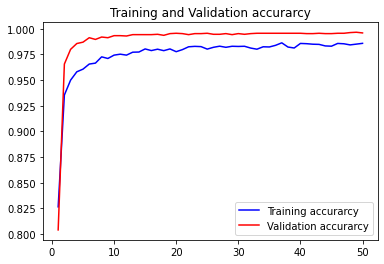

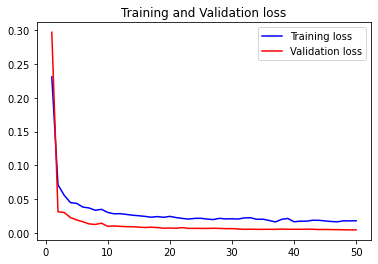

[INFO] Calculating model accuracy
94/94 [==============================] - 2s 16ms/step - loss: 0.0049 - accuracy: 0.9960
Test Accuracy: 99.59999918937683


In [12]:
Res_Plot_Test_Save('Mobilenet.h5')

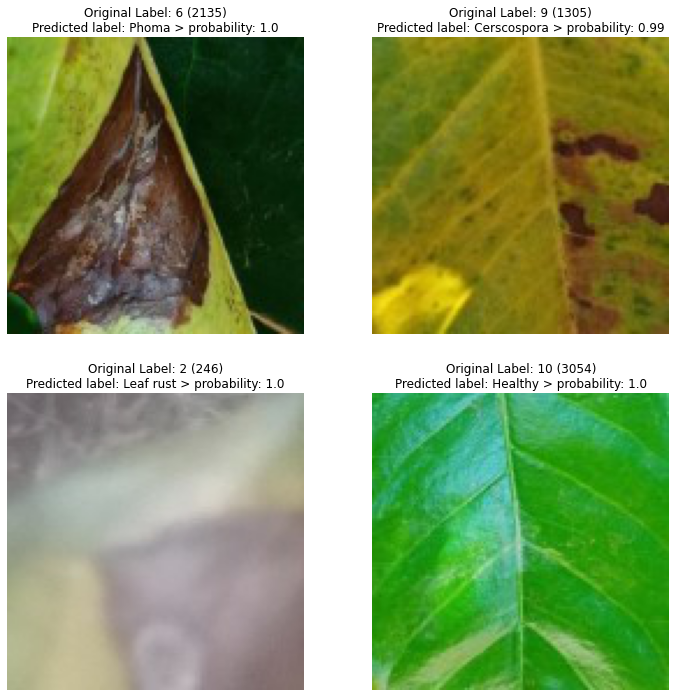

In [13]:
# create figure
fig = plt.figure(figsize=(12, 12))

# setting values to rows and column variables
rows = 2
columns = 2
  
# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)
  
# showing image
image_dir=directory_list[randint(0,len(directory_list))]
index1 = image_dir.rfind('/')
index2 = image_dir.rfind('.')
Image1 = plt.imread(image_dir)
im=convert_image_to_array(image_dir)
np_image_li = np.array(im, dtype=np.float16) / 225.0
npp_image = np.expand_dims(np_image_li, axis=0)
result=model.predict(npp_image)
itemindex = np.where(result==np.max(result))
plt.imshow(Image1)
plt.axis('off')
plt.title("Original Label: "+image_dir[index1+1:index2]+"\n"+"Predicted label: "+label_binarizer.classes_[itemindex[1][0]]+" > probability: "+str(np.max(result))[:4])
  
# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)
  
# showing image
image_dir=directory_list[randint(0,len(directory_list))]
index1 = image_dir.rfind('/')
index2 = image_dir.rfind('.')
Image2 = plt.imread(image_dir)
im=convert_image_to_array(image_dir)
np_image_li = np.array(im, dtype=np.float16) / 225.0
npp_image = np.expand_dims(np_image_li, axis=0)
result=model.predict(npp_image)
itemindex = np.where(result==np.max(result))
plt.imshow(Image2)
plt.axis('off')
plt.title("Original Label: "+image_dir[index1+1:index2]+"\n"+"Predicted label: "+label_binarizer.classes_[itemindex[1][0]]+" > probability: "+str(np.max(result))[:4])
  
# Adds a subplot at the 3rd position
fig.add_subplot(rows, columns, 3)
  
# showing image
image_dir=directory_list[randint(0,len(directory_list))]
index1 = image_dir.rfind('/')
index2 = image_dir.rfind('.')
Image3 = plt.imread(image_dir)
im=convert_image_to_array(image_dir)
np_image_li = np.array(im, dtype=np.float16) / 225.0
npp_image = np.expand_dims(np_image_li, axis=0)
result=model.predict(npp_image)
itemindex = np.where(result==np.max(result))
plt.imshow(Image3)
plt.axis('off')
plt.title("Original Label: "+image_dir[index1+1:index2]+"\n"+"Predicted label: "+label_binarizer.classes_[itemindex[1][0]]+" > probability: "+str(np.max(result))[:4])
  
# Adds a subplot at the 4th position
fig.add_subplot(rows, columns, 4)
  
# showing image
image_dir=directory_list[randint(0,len(directory_list))]
index1 = image_dir.rfind('/')
index2 = image_dir.rfind('.')
Image4 = plt.imread(image_dir)
im=convert_image_to_array(image_dir)
np_image_li = np.array(im, dtype=np.float16) / 225.0
npp_image = np.expand_dims(np_image_li, axis=0)
result=model.predict(npp_image)
itemindex = np.where(result==np.max(result))
plt.imshow(Image4)
plt.axis('off')
plt.title("Original Label: "+image_dir[index1+1:index2]+"\n"+"Predicted label: "+label_binarizer.classes_[itemindex[1][0]]+" > probability: "+str(np.max(result))[:4])
plt.show()